In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.models as models
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt

import os
import sys
os.path.dirname(sys.executable)
sys.path.append('/kuacc/users/ckoksal20/COMP547Project/SSuperGAN/')

In [3]:
from data.datasets.random_dataset import RandomDataset
from data.datasets.golden_panels import GoldenPanelsDataset
from data.augment import get_PIL_image

from networks.ssupervae import SSuperVAE
from networks.ssuper_dcgan import SSuperDCGAN
from training.vae_trainer import VAETrainer
from utils.config_utils import read_config, Config
from utils.logging_utils import *
from utils.plot_utils import *
from utils import pytorch_util as ptu

from configs.base_config import *
from functional.losses.elbo import elbo

Random Seed:  999


In [4]:
ptu.set_gpu_mode(True)
config = read_config(Config.SSUPERDCGAN)
golden_age_config = read_config(Config.GOLDEN_AGE)
model_path = "ckpts/ssuper_dcgan-checkpoint-epoch97.pth"

#N_SAMPLES = 1280 # 50000


In [5]:

net = SSuperDCGAN(config.backbone, 
                    latent_dim=config.latent_dim, 
                    embed_dim=config.embed_dim,
                    use_lstm=config.use_lstm,
                    seq_size=config.seq_size,
                    gen_img_size=config.image_dim,
                    lstm_hidden=config.lstm_hidden,
                    lstm_dropout=config.lstm_dropout,
                    fc_hidden_dims=config.fc_hidden_dims,
                    fc_dropout=config.fc_dropout,
                    num_lstm_layers=config.num_lstm_layers,
                    masked_first=config.masked_first,
                    ngpu = config.ngpu,
                    ngf = config.ngf,
                    ndf = config.ndf,
                    nc = config.nc,
                    image_size=config.image_dim).to(ptu.device) 


print(os.listdir())

net.load_state_dict(torch.load(model_path)['model_state_dict'])
net = net.cuda().eval()

dataset = GoldenPanelsDataset(golden_age_config.panel_path,
                              golden_age_config.sequence_path, 
                              golden_age_config.panel_dim,
                              config.image_dim, 
                              augment=False, 
                              mask_val=1, # mask with white color for 1 and black color for 0
                              mask_all=False, # masks faces from all panels and returns all faces
                              return_mask=True,
                              train_test_ratio=golden_age_config.train_test_ratio,
                              train_mode=False,
                              limit_size=-1)

data_loader = DataLoader(dataset, batch_size=1)

Loaded pretrained weights for efficientnet-b5
DCGAN PRAMS ngpu : 1  image_size : 64  nc : 3 latent_dim : 256  ngf : 64 ndf 64
['jupyter-2319746.log', '.ipynb_checkpoints', 'reconstruction_comparison.ipynb', 'baris.log', 'checkpoints', 'weights', 'eval_ssuper_dcgan.py', 'results_l1', 'samples_l1', 'weights_l1', 'jupyter-2319739.log', 'ssuper_dcgan_recon_tests.ipynb', 'v100_submit.sh', 'results', 'jupyter-2319709.log', 'ckpts', 'samples', 'ssuper_dcgan_play.py', 'jupyter-2319749.log', 'jupyter-2308066.log', 'ckpts_l1']


In [6]:
dl_iter = iter(data_loader)

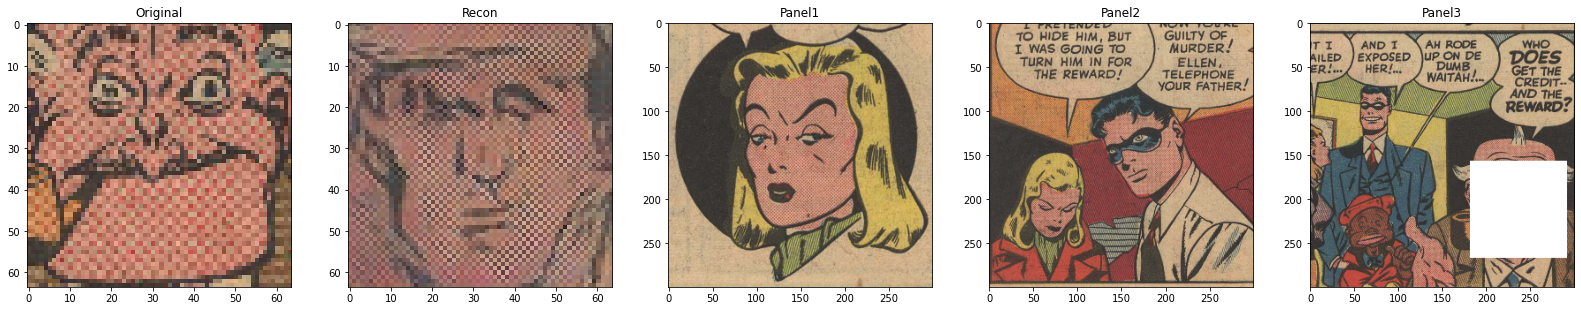

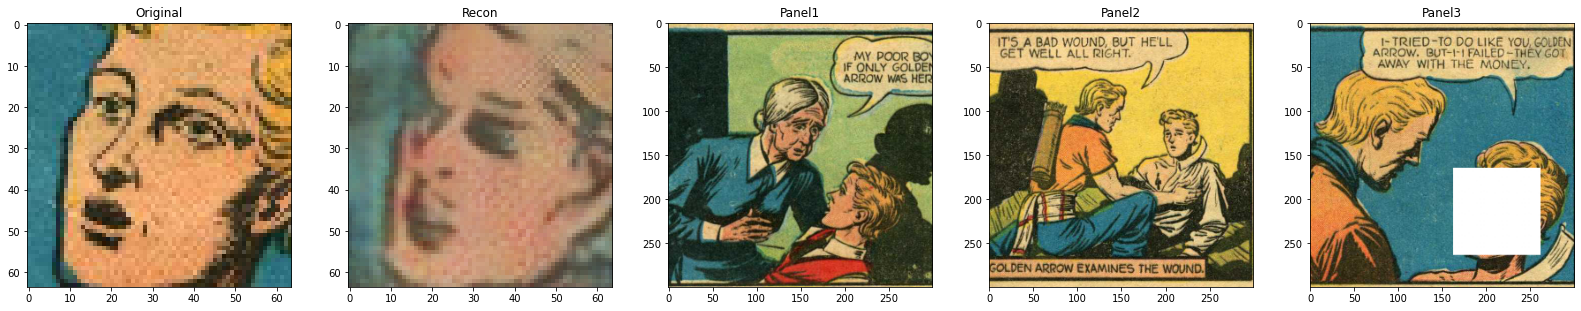

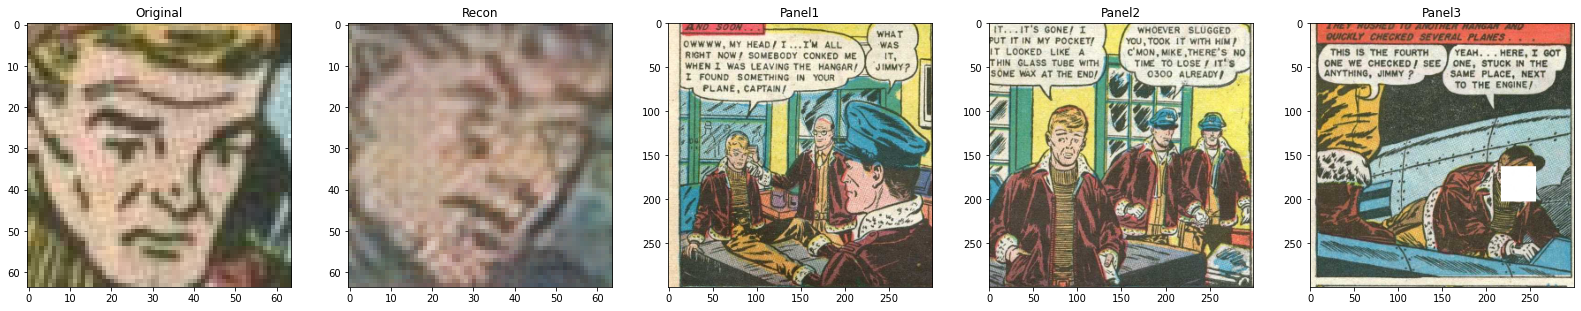

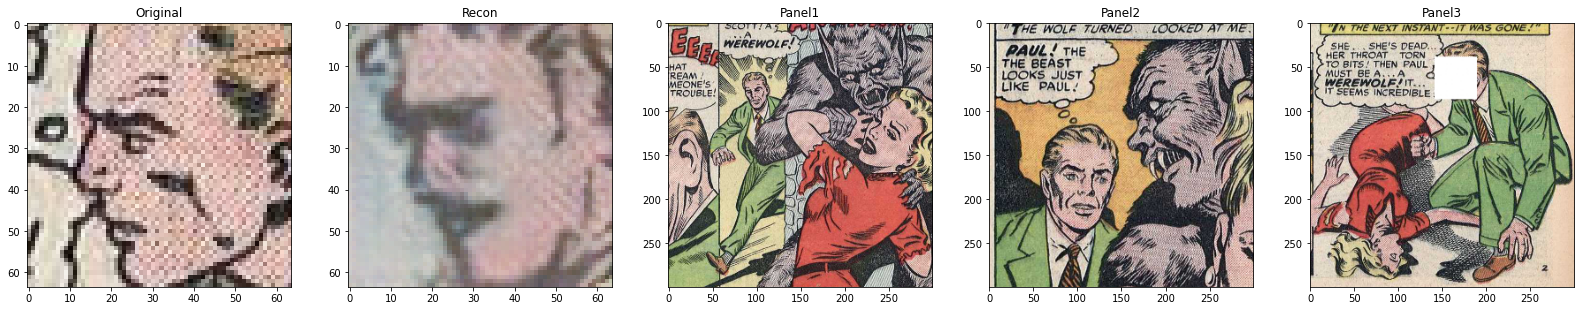

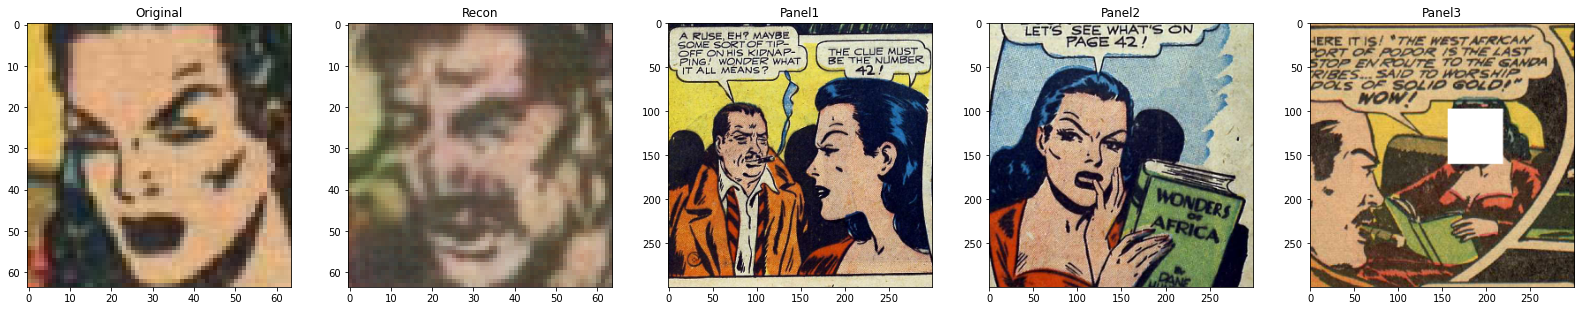

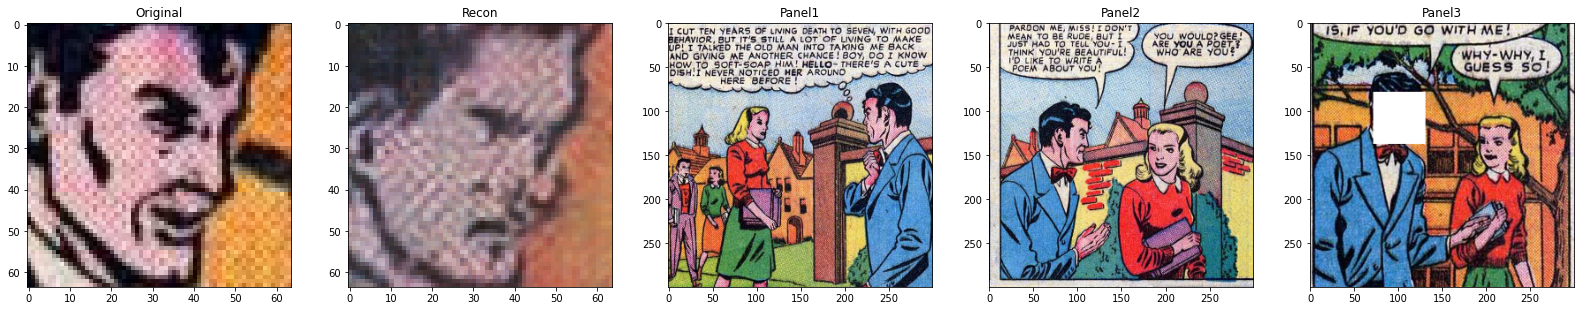

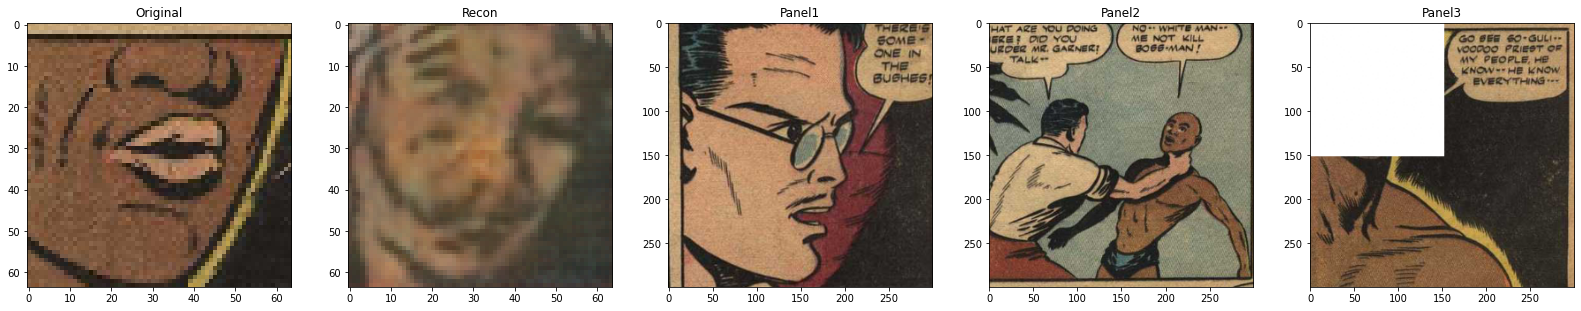

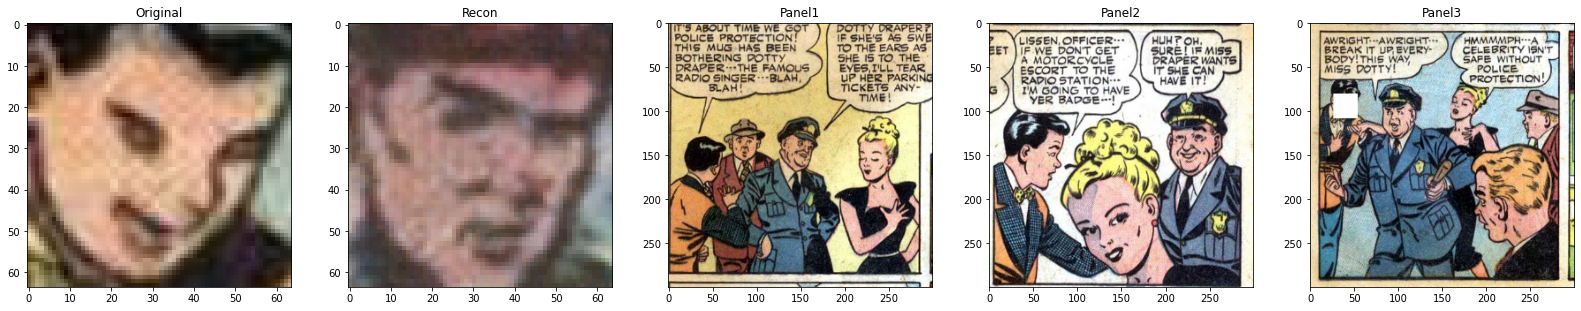

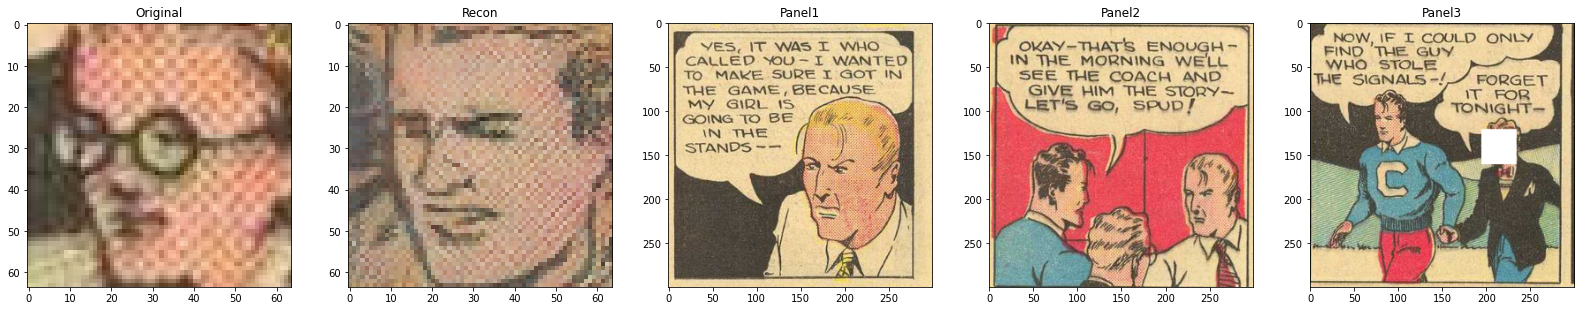

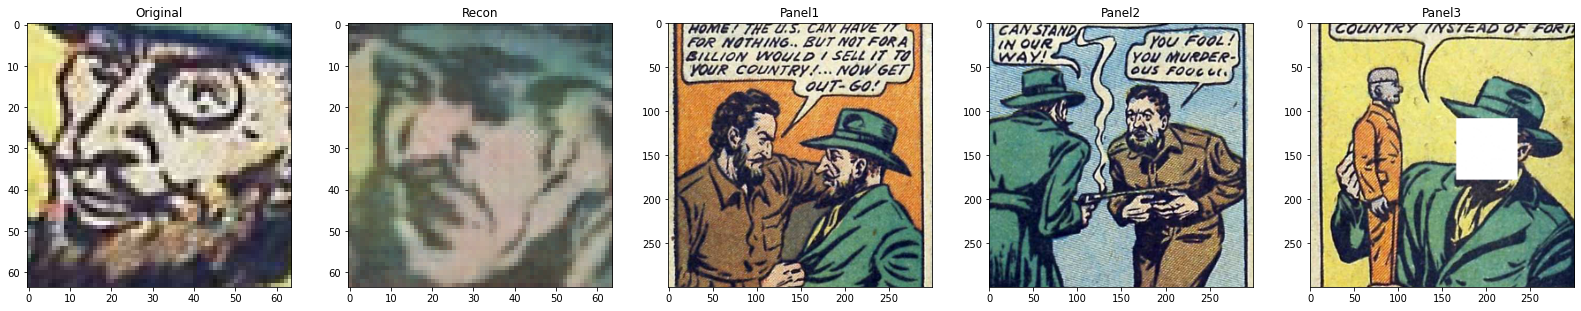

In [7]:
ctr, limit = 0, 10
x_arr = []
y_arr = []
z_arr = []
for _ in range(limit):
    x, y, z = next(dl_iter)
    x_arr.append(x)
    y_arr.append(y)
    z_arr.append(z)
    
    with torch.no_grad():
        _, _, _, y_recon, _ = net(x.cuda())   
    plot_panels_and_faces(x, y, y_recon)

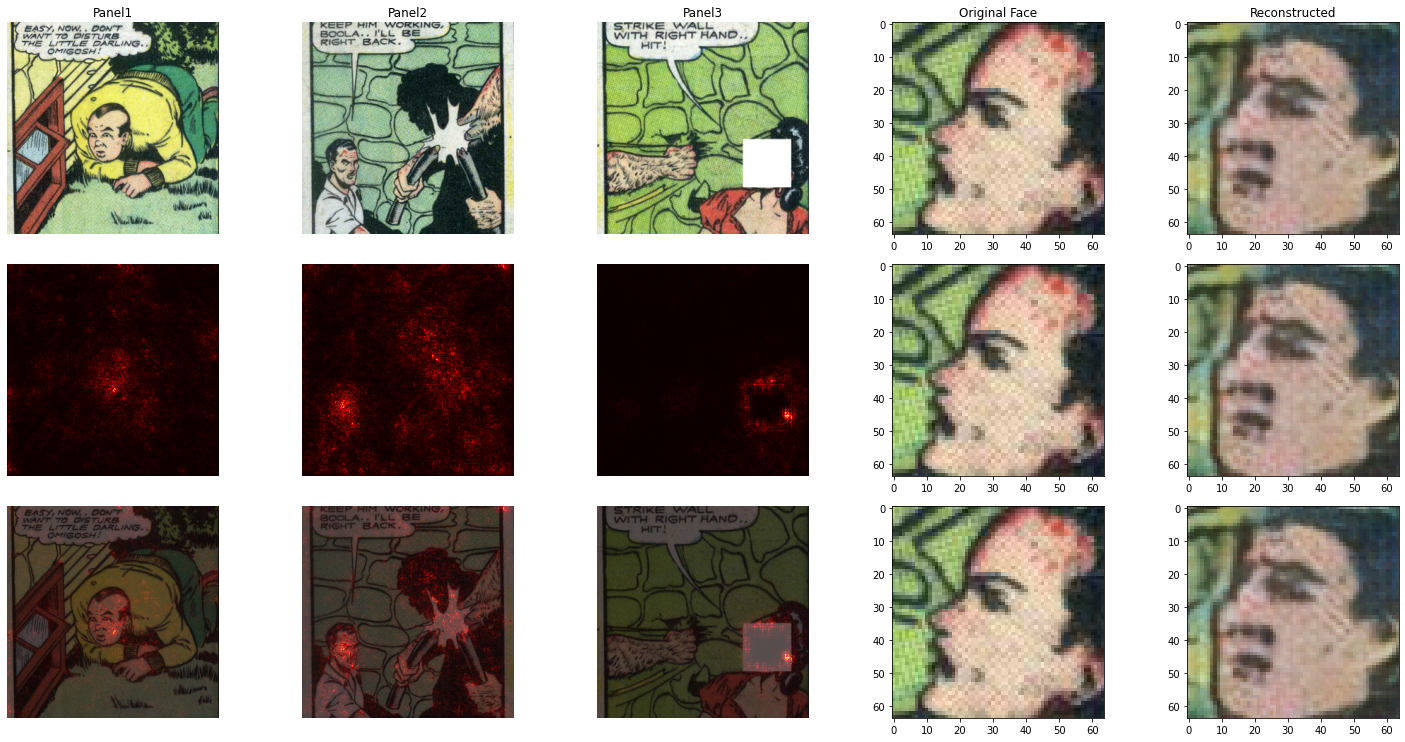

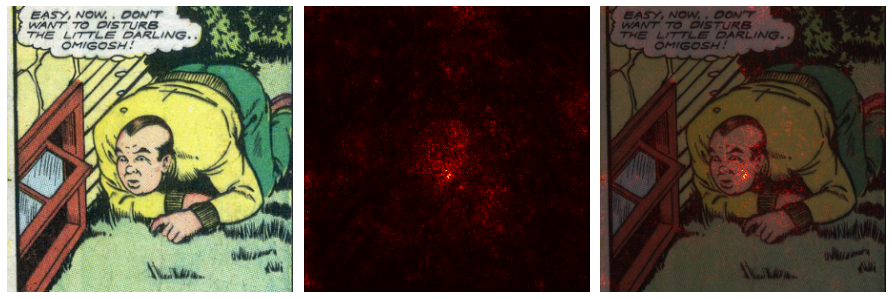

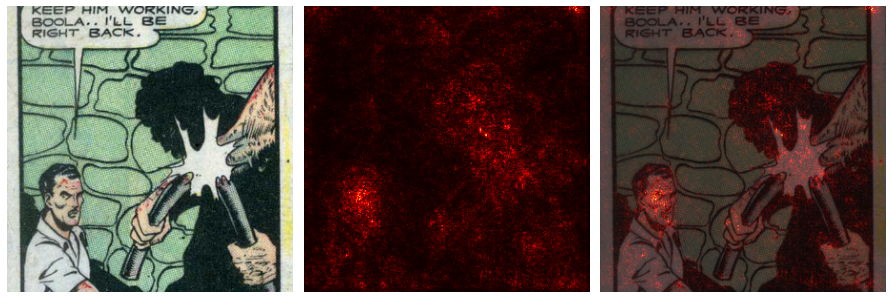

In [12]:
x, y, z = next(dl_iter)
draw_saliency(net, x, y)
draw_backbone_saliency(net.encoder.embedder, x, 0)
draw_backbone_saliency(net.encoder.embedder, x, 1)